<a href="https://colab.research.google.com/github/yifanzha-97/Neuro-Academy/blob/main/projects/behavior_and_theory/laquitaine_human_errors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Study Laquitaine & Gardner human motion direction estimation errors

author: steeve.laquitaine@epfl.ch

Inpired from [Laquitaine & Gardner, Neuron, 2018](https://doi.org/10.1016/j.neuron.2017.12.011)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, requests
from matplotlib import colors
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
from numpy import pi
from copy import copy

In [3]:
# @title Figure settings
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 11
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

TODO: ADD VIDEO OF TASK AND FIGURE OF EXPERIMENT

In [4]:
# @title Data retrieval

url = "https://raw.githubusercontent.com/yifanzha-97/Neuro-Academy/main/data02_direction1prior.csv"
data = pd.read_csv(url)

In [5]:
# @title Data loading
data.head()

,trial_index,trial_time,response_arrow_start_angle,motion_direction,motion_coherence,estimate_x,estimate_y,reaction_time,raw_response_time,prior_std,prior_mean,subject_id,experiment_name,session_id,run_id
0,1,0.000000,45,95,0.06,-2.146350,1.281867,2.490958,3.795740,80,225,1,data02_direction1prior,1,1
1,2,4.016433,80,195,0.12,0.759598,2.381808,2.672841,7.979744,80,225,1,data02_direction1prior,1,1
2,3,8.201921,76,295,0.24,-2.455078,-0.471794,3.439310,12.931740,80,225,1,data02_direction1prior,1,1
3,4,13.155035,162,275,0.06,-1.811494,1.722930,2.846508,17.299760,80,225,1,data02_direction1prior,1,1
4,5,17.523458,154,285,0.12,1.928807,-1.590504,2.949835,21.763749,80,225,1,data02_direction1prior,1,1


### Data dictionary

`data` contains sessions from 12 human subjects, data from [Laquitaine & Gardner, 2018](https://doi.org/10.1016/j.neuron.2017.12.011).

Subjects had to estimate the direction of stimulus motion directions.

* `data['trial_index']`: trial index
* `data['trial_time']`: time at which trial starts with th e central fixation dot
* `data['response_arrow_start_angle']`: the angle of the response arrow at the start of the response phase.
* `data['motion_direction']`: the stimulus motion direction
* `data['motion_coherence']`: the stimulus motion coherence
* `data['estimate_x']`: x cartesian coordinate of the stimulus motion direction
* `data['estimate_y']`: y cartesian coordinate of the stimulus motion direction
* `data['reaction_time']`: subject's reaction time
* `data['raw_response_time']`: subject response time since the start of the run (of about 200 trials)
* `data['prior_std']`: It is the standard deviation of the statistical distribution (motion direction generative process over trials, which we call "experimental prior") from which we sampled the stimulus motion direction displayed in each trial.
* `data['prior_mean']`: the most frequently displayed motion direction. It is the mean of the statistical distribution (motion direction generative process over trials, which we call "experimental prior") from which we sampled the stimulus motion direction displayed in each trial.
* `data['subject_id']`: the id of the subject for which behavior was recorded.
* `data['experiment_name']`: the name of the experiment,i.e."data02_direction1prior". The mean of the "experimental prior"  was fixed at 225 deg.
* `data['session_id']`: the id of the session.
* `data['run_id']`: the id of the run.


The complete original dataset is stored in .mat files here: https://data.mendeley.com/datasets/nxkvtrj9ps/1.

### Basic data exploration

Look at the number of sessions and prior runs performed by the subject with subject_id = 1, as well as the prior runs and motion coherences he was exposed to.
Note that one of three coherences was randomly chosen for each trial within a prior run, which typically lasted 200 trials.

In [6]:
# @title Experiment design for an example subject

# get subject 1's dataset
sub01_data = data[(data["subject_id"]==3)][["subject_id", "trial_index", "session_id", "run_id", "prior_std", "motion_coherence", "motion_direction", "estimate_x", "estimate_y"]]
# count the number of trials by run and session
sub01_data.groupby(["subject_id", "session_id", "run_id", "prior_std", "motion_coherence"])[["trial_index"]].count()

trial_index
subject_id session_id run_id prior_std motion_coherence             
3          1          1      80        0.06                      109
                                       0.12                       75
                                       0.24                       42
                      2      80        0.06                      109
                                       0.12                       75
...                                                              ...
                      39     80        0.12                       75
                                       0.24                       42
                      40     80        0.06                      109
                                       0.12                       75
                                       0.24                       42

[118 rows x 1 columns]

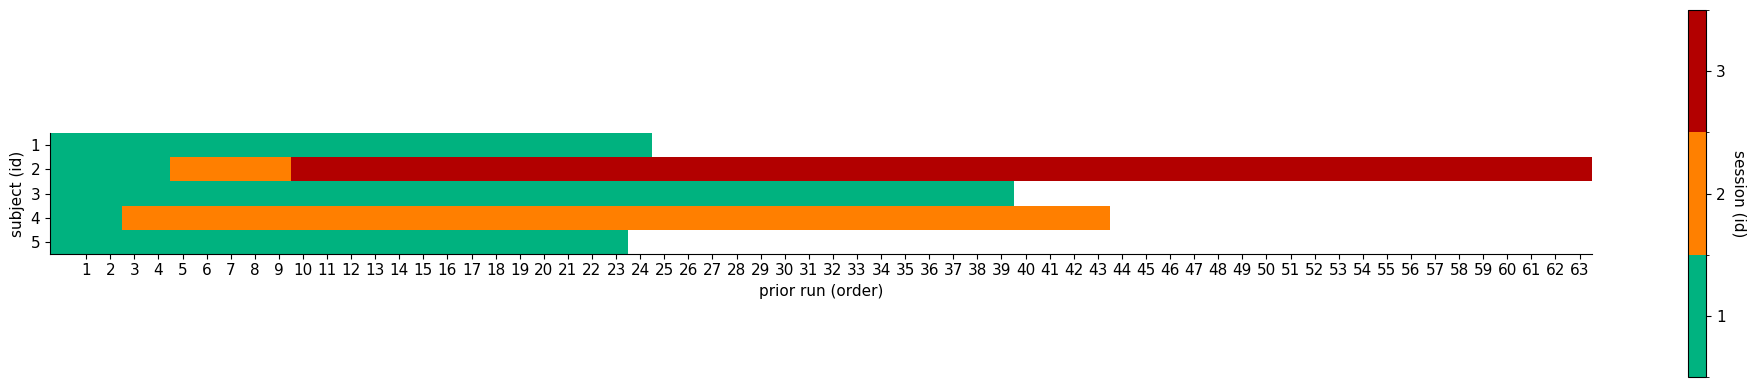

In [7]:
# @title Temporal order of prior runs by subject for the first session
subject_id_set = data["subject_id"].unique()
n_subjects = len(subject_id_set)
prior_runs_all = []
max_nb_runs = 0

# get sequence of prior runs for each subject
for subject_id in subject_id_set:

  # get subject's dataset
  sub01_data = data[(data["subject_id"]==subject_id)][["subject_id", "trial_index", "session_id", "run_id", "motion_coherence"]]

  # plot the ordering of prior runs
  gp = sub01_data.groupby(["subject_id", "session_id", "run_id"])[["trial_index"]].count()
  prior_runs = gp.reset_index()["session_id"].values
  prior_runs_all.append(list(prior_runs))
  max_nb_runs = max(max_nb_runs, len(prior_runs))

# create a matrix that contains the sequence of all subjects' prior runs
run_order_matrix = np.zeros((n_subjects, max_nb_runs))*np.nan
for sub_ix, _ in enumerate(subject_id_set):
  run_order_matrix[sub_ix, 0: len(prior_runs_all[sub_ix])] = prior_runs_all[sub_ix]

# init figure
fig, ax = plt.subplots(1,1)

# create custom colormap
cmp = ListedColormap([[0,.7,.5], [1,.5,0], [1,0,0], [0.7,0,0]])

# set colormap bounds
bounds = [0.5, 1.5, 2.5, 3.5]
norm = colors.BoundaryNorm(bounds, cmp.N)

# plot sequence of prior runs
plt.imshow(run_order_matrix, cmap=cmp, norm=norm)

# setup x legend
ax.set_xticks(np.arange(1, run_order_matrix.shape[1],1))
ax.set_xticklabels(np.arange(1, run_order_matrix.shape[1],1))
ax.set_xlabel("prior run (order)")

# setup y legend
ax.set_yticks(np.arange(0, run_order_matrix.shape[0],1))
ax.set_yticklabels(subject_id_set)
ax.set_ylabel("subject (id)")

# setup colobar
cbar = plt.colorbar()
cbar.ax.get_yaxis().set_ticks([1,2,3])
cbar.ax.get_yaxis().labelpad = 15;
cbar.ax.set_ylabel('session (id)', rotation=270);

In [8]:
# @title Basic plots of subject estimate average by task conditions

# circular statistics utils
# -------------------
def get_cartesian_to_deg(
    x: np.ndarray, y: np.ndarray, signed: bool
) -> np.ndarray:
    """convert cartesian coordinates to
    angles in degree
    Args:
        x (np.ndarray): x coordinate
        y (np.ndarray): y coordinate
        signed (boolean): True (signed) or False (unsigned)
    Usage:
        .. code-block:: python
            import numpy as np
            from bsfit.nodes.cirpy.utils import get_cartesian_to_deg
            x = np.array([1, 0, -1, 0])
            y = np.array([0, 1, 0, -1])
            degree = get_cartesian_to_deg(x,y,False)
            # Out: array([  0.,  90., 180., 270.])
    Returns:
        np.ndarray: angles in degree
    """
    # convert to radian (ignoring divide by 0 warning)
    with np.errstate(divide="ignore"):
        degree = np.arctan(y / x)

    # convert to degree and adjust based
    # on quadrant
    for ix in range(len(x)):
        if (x[ix] >= 0) and (y[ix] >= 0):
            degree[ix] = degree[ix] * 180 / np.pi
        elif (x[ix] == 0) and (y[ix] == 0):
            degree[ix] = 0
        elif x[ix] < 0:
            degree[ix] = degree[ix] * 180 / np.pi + 180
        elif (x[ix] >= 0) and (y[ix] < 0):
            degree[ix] = degree[ix] * 180 / np.pi + 360

    # if needed, convert signed to unsigned
    if not signed:
        degree[degree < 0] = degree[degree < 0] + 360
    return degree

def get_deg_to_rad(deg: np.array, signed: bool):
    """convert angles in degree to radian
    Args:
        deg (np.array): angles in degree
        signed (bool): True (signed) or False (unsigned)
    Usage:
        .. code-block:: python
            import numpy as np
            from bsfit.nodes.cirpy.utils import get_deg_to_rad
            radians = get_deg_to_rad(np.array([0, 90, 180, 270], True)
            Out: array([ 0., 1.57079633, 3.14159265, -1.57079633])
    Returns:
        np.ndarray: angles in radian
    """
    # get unsigned radians (1:2*pi)
    rad = (deg / 360) * 2 * pi

    # get signed radians(-pi:pi)
    if signed:
        rad[deg > 180] = (deg[deg > 180] - 360) * (
            2 * pi / 360
        )
    return rad

def get_polar_to_cartesian(
    angle: np.ndarray, radius: float, type: str
) -> dict:
    """convert angle in degree or radian to cartesian coordinates
    Args:
        angle (np.ndarray): angles in degree or radian
        radius (float): radius
        type (str): "polar" or "radian"
    Usage:
        .. code-block:: python
            import numpy as np
            from bsfit.nodes.cirpy.utils import get_polar_to_cartesian
            degree = np.array([0, 90, 180, 270])
            cartesian = get_polar_to_cartesian(degree, 1, "polar")
            cartesian.keys()

            # Out: dict_keys(['deg', 'rad', 'cart'])

            cartesian["cart"]

            # Out: array([[ 1.,  0.],
            #            [ 0.,  1.],
            #            [-1.,  0.],
            #            [-0., -1.]])
    Returns:
        dict: _description_
    """
    # convert to radian if needed
    theta = dict()
    if type == "polar":
        theta["deg"] = angle
        theta["rad"] = angle * np.pi / 180
    elif type == "radian":
        theta["deg"] = get_deg_to_rad(angle, False)
        theta["rad"] = angle

    # convert to cartesian coordinates
    x = radius * np.cos(theta["rad"])
    y = radius * np.sin(theta["rad"])

    # round to 10e-4
    x = np.round(x, 4)
    y = np.round(y, 4)

    # reshape as (N angles x 2 coord)
    theta["cart"] = np.vstack([x, y]).T
    return theta

def get_circ_weighted_mean_std(
    angle: np.ndarray, proba: np.ndarray, type: str
) -> dict:
    """calculate circular data statistics
    Args:
        angle (np.ndarray): angles in degree or cartesian coordinates
        proba (np.ndarray): each angle's probability of occurrence
        type (str): "polar" or "cartesian"
    Usage:
        .. code-block:: python
            import numpy as np
            from bsfit.nodes.cirpy.utils import get_circ_weighted_mean_std
            degree = np.array([358, 0, 2, 88, 90, 92])
            proba = np.array([1, 1, 1, 1, 1, 1])/6
            output = get_circ_weighted_mean_std(degree, proba, "polar")
            output.keys()
            # Out: dict_keys(['coord_all', 'deg_all', 'coord_mean', 'deg_mean',
            #               'deg_all_for_std', 'deg_mean_for_std', 'deg_var',
            #               'deg_std', 'deg_sem'])
            output["deg_mean"]
            # Out: array([45.])
            output["deg_std"]
            # array([45.02961988])
    Returns:
        (dict): angle summary statistics (mean, std, var, sem)

    Raises:
        ValueError: type is not "polar" or "cartesian"
    """

    angle = angle.copy()

    # if polar, convert to cartesian
    if type == "polar":
        radius = 1
        coord = get_polar_to_cartesian(
            angle, radius=radius, type="polar"
        )
    elif type == "cartesian":
        coord = angle
    else:
        raise ValueError(
            """ "type" can either be "polar" or "cartesian" value """
        )

    # store angles
    data = dict()
    data["coord_all"] = coord["cart"]
    data["deg_all"] = coord["deg"]

    # calculate mean
    # ..............
    proba_for_mean = np.tile(proba[:, None], 2)
    data["coord_mean"] = np.sum(
        proba_for_mean * data["coord_all"], 0
    )
    data["coord_mean"] = data["coord_mean"][:, None]
    data["deg_mean"] = get_cartesian_to_deg(
        data["coord_mean"][0],
        data["coord_mean"][1],
        signed=False,
    )

    # calculate std
    # ..............
    n_data = len(data["deg_all"])
    data["deg_all_for_std"] = data["deg_all"]
    data["deg_mean_for_std"] = np.tile(
        data["deg_mean"], n_data
    )

    # apply corrections
    # when 0 <= mean <= 180
    if data["deg_mean"] + 180 <= 360:
        for ix in range(n_data):
            if (
                data["deg_all"][ix]
                >= data["deg_mean"] + 180
            ):
                data["deg_all_for_std"][ix] = (
                    data["deg_all"][ix] - 360
                )
    else:
        # when 180 <= mean <= 360
        for ix in range(n_data):
            if (
                data["deg_all"][ix]
                <= data["deg_mean"] - 180
            ):
                data["deg_mean_for_std"][ix] = (
                    data["deg_mean"] - 360
                )

    # calculate variance, standard deviation and
    # standard error to the mean
    data["deg_var"] = np.array(
        [
            sum(
                proba
                * (
                    data["deg_all_for_std"]
                    - data["deg_mean_for_std"]
                )
                ** 2
            )
        ]
    )
    data["deg_std"] = np.sqrt(data["deg_var"])
    data["deg_sem"] = data["deg_std"] / np.sqrt(n_data)
    return data

def get_signed_angle(
    origin: np.ndarray, destination: np.ndarray, type: str
):
    """get the signed angle difference between origin and destination angles
    Args:
        origin (np.ndarray): origin angle
        destination (np.ndarray): destination angle
        type (str): angle type ("polar", "radian", "cartesian")
    Usage:
        .. code-block:: python
            angle = get_signed_angle(90, 45, 'polar')

            # Out: array([45.])

            angle = get_signed_angle(90, 45, 'radian')
            # Out: array([58.3103779])
            origin = np.array([[0, 1]])
            destination = np.array([[1, 0]])
            angle = get_signed_angle(origin, destination, "cartesian")

            # Out: array([90.])
    Returns:
        (np.ndarray): signed angle differences
    """

    # convert to cartesian coordinates
    if type == "polar" or type == "radian":
        origin_dict = get_polar_to_cartesian(
            origin, radius=1, type=type
        )
        destination_dict = get_polar_to_cartesian(
            destination, radius=1, type=type
        )
    elif type == "cartesian":
        origin_dict = dict()
        destination_dict = dict()
        origin_dict["cart"] = origin
        destination_dict["cart"] = destination

    # get coordinates
    xV1 = origin_dict["cart"][:, 0]
    yV1 = origin_dict["cart"][:, 1]
    xV2 = destination_dict["cart"][:, 0]
    yV2 = destination_dict["cart"][:, 1]

    # Calculate the angle separating the
    # two vectors in degrees
    angle = -(180 / np.pi) * np.arctan2(
        xV1 * yV2 - yV1 * xV2, xV1 * xV2 + yV1 * yV2
    )
    return angle

def get_combination_set(database: np.ndarray):
    """get the set of row combinations

    Args:
        database (np.ndarray): an N-D array

    Returns:
        (np.ndarray, np.ndarray, np.ndarray): `combs` is the set
        of combinations, `b` are the row indices for each combination
        in database, `c` are the rows indices for each combination in
        combs.
    """
    combs, ia, ic = np.unique(
        database,
        return_index=True,
        return_inverse=True,
        axis=0,
    )
    return (combs, ia, ic)

def get_data_stats(data: pd.Series, output: dict):
    """calculate data statistics

    Args:
        data (pd.Series): stimulus feature estimates
        output (dict): ::

            'PestimateGivenModel': estimate probabilities
            'map': max-a-posteriori percepts
            'conditions': task conditions

    Returns:
        (dict): returns data mean and std to output
    """
    # get conditions
    cond = output["conditions"]

    # initialise statistics
    data_mean = []
    data_std = []

    # get set of conditions
    cond_set, ix, _ = get_combination_set(cond)

    # record stats by condition
    for c_i in range(len(cond_set)):

        # find condition's instances
        loc_1 = cond[:, 0] == cond_set[c_i, 0]
        loc_2 = cond[:, 1] == cond_set[c_i, 1]
        loc_3 = cond[:, 2] == cond_set[c_i, 2]

        # get associated data
        data_c_i = data.values[loc_1 & loc_2 & loc_3]

        # set each instance with equal probability
        trial_proba = np.tile(
            1 / len(data_c_i), len(data_c_i)
        )

        # get statistics
        stats = get_circ_weighted_mean_std(
            data_c_i, trial_proba, type="polar",
        )

        # record statistics
        data_mean.append(stats["deg_mean"])
        data_std.append(stats["deg_std"])

    # record statistics
    output["data_mean"] = np.array(data_mean)
    output["data_std"] = np.array(data_std)

    # record their condition
    output["conditions"] = cond_set
    return output


# Visualization utils
# -------------------
def plot_mean(
    data_mean: np.ndarray,
    data_std: np.ndarray,
    condition: np.ndarray,
    prior_mode: float,
    centering: bool,
):
    """plot data and prediction mean and std
    for three conditions (x-axis, colors and panels)
    Args:
        data_mean (np.ndarray): data mean by condition
        data_std (np.ndarray): data std by condition
        prediction_mean (np.ndarray): prediction mean by condition
        prediction_std (np.ndarray): prediction std by condition
        condition (np.ndarray): associated conditions
        prior_mode (float): the mode of the prior
        centering (bool): center x-axis or not
    Returns:
        _type_: _description_
    """
    # get condition levels
    levels_1 = np.flip(np.unique(condition[:, 0]))
    levels_2 = np.flip(np.unique(condition[:, 1])) # sort in decreasing order
    levels_3 = np.unique(condition[:, 2])

    # set x_tick
    x_tick_centered = get_signed_angle(
        levels_1, prior_mode, "polar"
    )
    x_tick_centered[x_tick_centered == -180] = 180
    i_sort = np.argsort(x_tick_centered)
    x_tick_centered = x_tick_centered[i_sort]
    y_tick_centered = x_tick_centered

    # set colors
    levels_2_color = [
        [0.5, 0, 0],
        [1, 0.2, 0],
        [1, 0.6, 0],
        [0.75, 0.75, 0],
    ]

    plt.figure(figsize=(10,3))

    # loop over conditions and plot data
    # and prediction stats
    for level2_ix in range(len(levels_2)):

        # set condition 2 in column panels
        plt.subplot(1, len(levels_2), level2_ix + 1)

        # set condition 3 within panels
        for level1_ix in range(len(levels_1)):

            # find condition's instances
            loc_lev1 = (
                condition[:, 0] == levels_1[level1_ix]
            )
            loc_lev2 = (
                condition[:, 1] == levels_2[level2_ix]
            )
            loc_condition = loc_lev2 & loc_lev1

            # center to prior mode
            x_centered = condition[:, 2][loc_condition]
            if centering:
                x_centered = np.round(
                    get_signed_angle(
                        x_centered, prior_mode, "polar",
                    )
                )

            x_centered[x_centered == -180] = 180

            # make 2-D array
            x_centered = x_centered[:, None]

            # sort data stats
            y_data_centered = data_mean[loc_condition]
            y_data_std_centered = data_std[loc_condition]

            # sort all
            i_sort = np.argsort(x_centered.squeeze())
            x_centered = x_centered[i_sort]
            y_data_centered = y_data_centered[i_sort]
            y_data_std_centered = y_data_std_centered[
                i_sort
            ]

            # To plot estimates mean against circular stimulus
            # feature on a linear space, the raw stimulus feature and
            # estimates mean are normalized to vectorial angles from
            # the prior mode and x and y axes are centered at zero
            # (normalized prior mode) via a circular shift. Rotation
            # angles were then labelled according to their raw values
            # on the circle (e.g., 0, is labelled 225). A mean estimate
            # of 33 degree was calculated for 55 degree which is very far
            # from stimulus feature on the linear space but actually close
            # to stimulus feature on the circular space. We got rid of
            # this visual artifact by expressing both 55 and 33 as the
            # counterclockwise distance to prior mode (e.g., for a prior
            # mode 225 55 becomes 190 instead of 170 and 33 becomes 168).
            # Note that the maximum vectorial angle is >180.
            if (level2_ix == 3) & (not 180 in x_centered):

                # move point at -170? distance to prior at 190? (positive
                # side) and convert values at x=-170? to positive distance
                # relative to prior to improve visualization
                posNeg170 = x_centered == -170
                x_centered[posNeg170] = (
                    prior_mode - 170 + 360 - prior_mode
                )
                x_centered[x_centered == 180] = -180
                y_data_centered[posNeg170] = (
                    prior_mode
                    - abs(y_data_centered[posNeg170])
                    + 360
                    - prior_mode
                )

                # sort x-axis
                i_sort = np.argsort(x_centered)
                x_centered = x_centered[i_sort]

                # sort y-axis
                y_data_centered = y_data_centered[i_sort]

                # set ticks
                x_tick_centered = x_centered

            # plot data stats
            plt.errorbar(
                x_centered.squeeze(),
                y_data_centered.squeeze(),
                yerr=y_data_std_centered.squeeze(),
                marker="o",
                markersize=7,
                markeredgecolor="w",
                linestyle="None",
                linewidth=1,
                color=levels_2_color[level1_ix],
                ecolor=levels_2_color[level1_ix],
            )
            plt.ylim([-0, 360])
            plt.hlines(prior_mode, -180, 180, linestyle=':')
            plt.xticks([-160, -80, 0, 80, 160], [-160, -80, 0, 80, 160])
            plt.yticks([67, 147, 227, 307, 387], [-160, -80, 0, 80, 160])
            plt.xlabel("Motion direction distance" "\n" "relative to the prior mean" "\n" "(deg)")
            if level2_ix == 0:
              plt.ylabel("Mean estimates distance" "\n" "relative to the prior mean" "\n" "(deg)")
        plt.title(f"{int(levels_2[level2_ix]*100)}% coherence", fontsize=12)
    plt.show()
    return None

Priors are color coded (green: 10 deg, orange: 20 deg, red: 40 deg, dark red: 80 deg)

/tmp/ipython-input-8-725447372.py:207: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data["deg_mean_for_std"][ix] = (


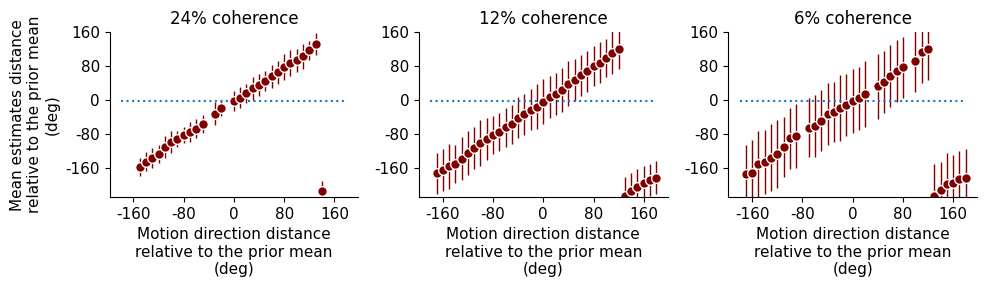

In [9]:
# convert subject estimate cartesian coordinates to degrees
estimates_deg = get_cartesian_to_deg(data["estimate_x"].values, data["estimate_y"].values, False)
estimates_deg = np.round(estimates_deg)

# calculate estimate circular summary statistics by experimental condition
stats = dict()
stats["conditions"] = data[["prior_std", "motion_coherence", "motion_direction"]].values
stats = get_data_stats(pd.Series(estimates_deg), stats)

# plot estimate average
plot_mean(
  stats["data_mean"],
  stats["data_std"],
  stats["conditions"],
  prior_mode=225,
  centering=True
)

/tmp/ipython-input-8-725447372.py:207: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data["deg_mean_for_std"][ix] = (


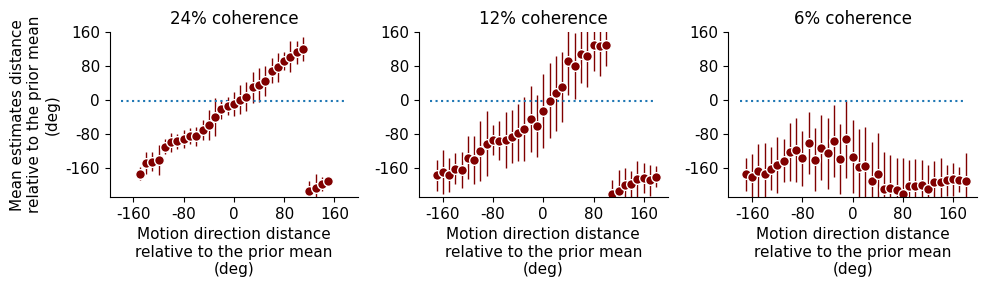

/tmp/ipython-input-8-725447372.py:207: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data["deg_mean_for_std"][ix] = (


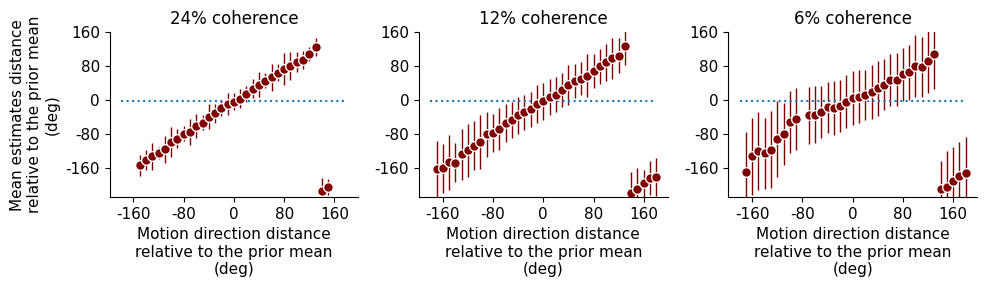

/tmp/ipython-input-8-725447372.py:207: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data["deg_mean_for_std"][ix] = (


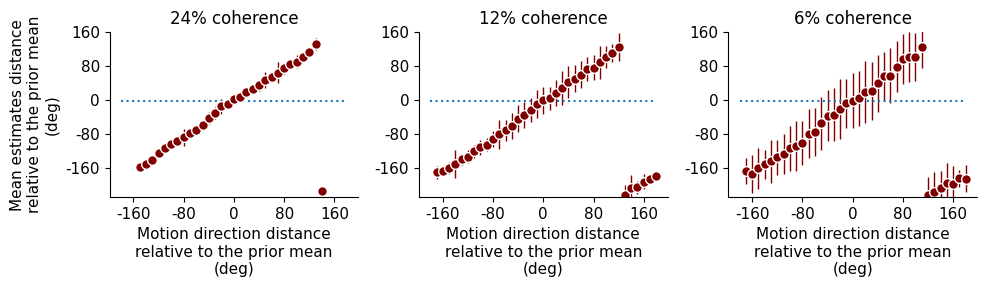

/tmp/ipython-input-8-725447372.py:207: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data["deg_mean_for_std"][ix] = (


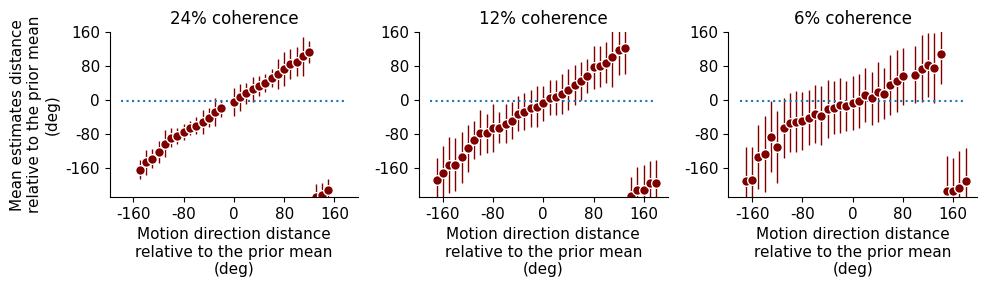

/tmp/ipython-input-8-725447372.py:207: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data["deg_mean_for_std"][ix] = (


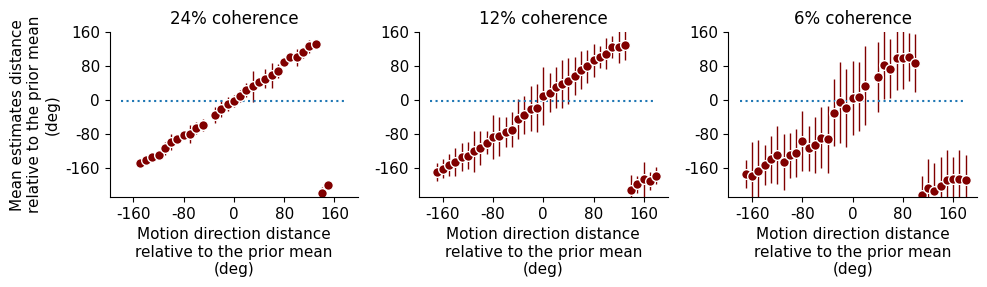

In [10]:
# @title Plots of estimate average by task condition and subject

subject_id_set = data["subject_id"].unique()

for sub_id in subject_id_set:

  dataset = data[data["subject_id"]==sub_id]

  # convert subject estimate cartesian coordinates to degrees
  estimates_deg = get_cartesian_to_deg(dataset["estimate_x"].values, dataset["estimate_y"].values, False)
  estimates_deg = np.round(estimates_deg)

  # calculate estimate circular summary statistics by experimental condition
  stats = dict()
  stats["conditions"] = dataset[["prior_std", "motion_coherence", "motion_direction"]].values
  stats = get_data_stats(pd.Series(estimates_deg), stats)

  # plot estimate average
  plot_mean(
    stats["data_mean"],
    stats["data_std"],
    stats["conditions"],
    prior_mode=225,
    centering=True
  )

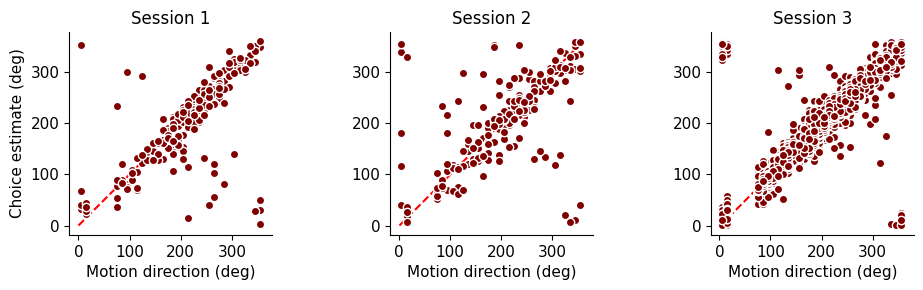

In [14]:
# @title Plot session time course of subject 1's individual trial estimates (24% coh, 80 deg prior)

# set parameters
SUBJECT_ID = 2
COHERENCE = 0.24
PRIOR_STD = 80

# set session ids
session_ids = [1,2,3]

fig, axes = plt.subplots(1,len(session_ids), figsize=(10,3))

for ix, session_id in enumerate(session_ids):

  # query the data we need
  tmp = data[(data["subject_id"]==SUBJECT_ID) & (data["session_id"]==session_id) & (data["motion_coherence"]==COHERENCE) & (data["prior_std"]==PRIOR_STD)]

  # get data
  motion_direction = tmp["motion_direction"].values
  estimates_deg = np.round(get_cartesian_to_deg(tmp["estimate_x"].values, tmp["estimate_y"].values, False))

  # plot subject 01's estimates against true motion direction
  axes[ix].plot([ix, 360], [0, 360], "r--");
  axes[ix].plot(motion_direction, estimates_deg, color=[0.5, 0, 0], marker="o", linestyle="None", markersize=6, markeredgecolor="w");
  axes[ix].set_xlabel("Motion direction (deg)");
  if ix==0:
    axes[ix].set_ylabel("Choice estimate (deg)");
  axes[ix].set_xlim([0, 360]);
  axes[ix].set_ylim([0, 360]);
  axes[ix].axis("square");
  axes[ix].set_title(f"Session {session_id}", fontsize=12)
plt.tight_layout()

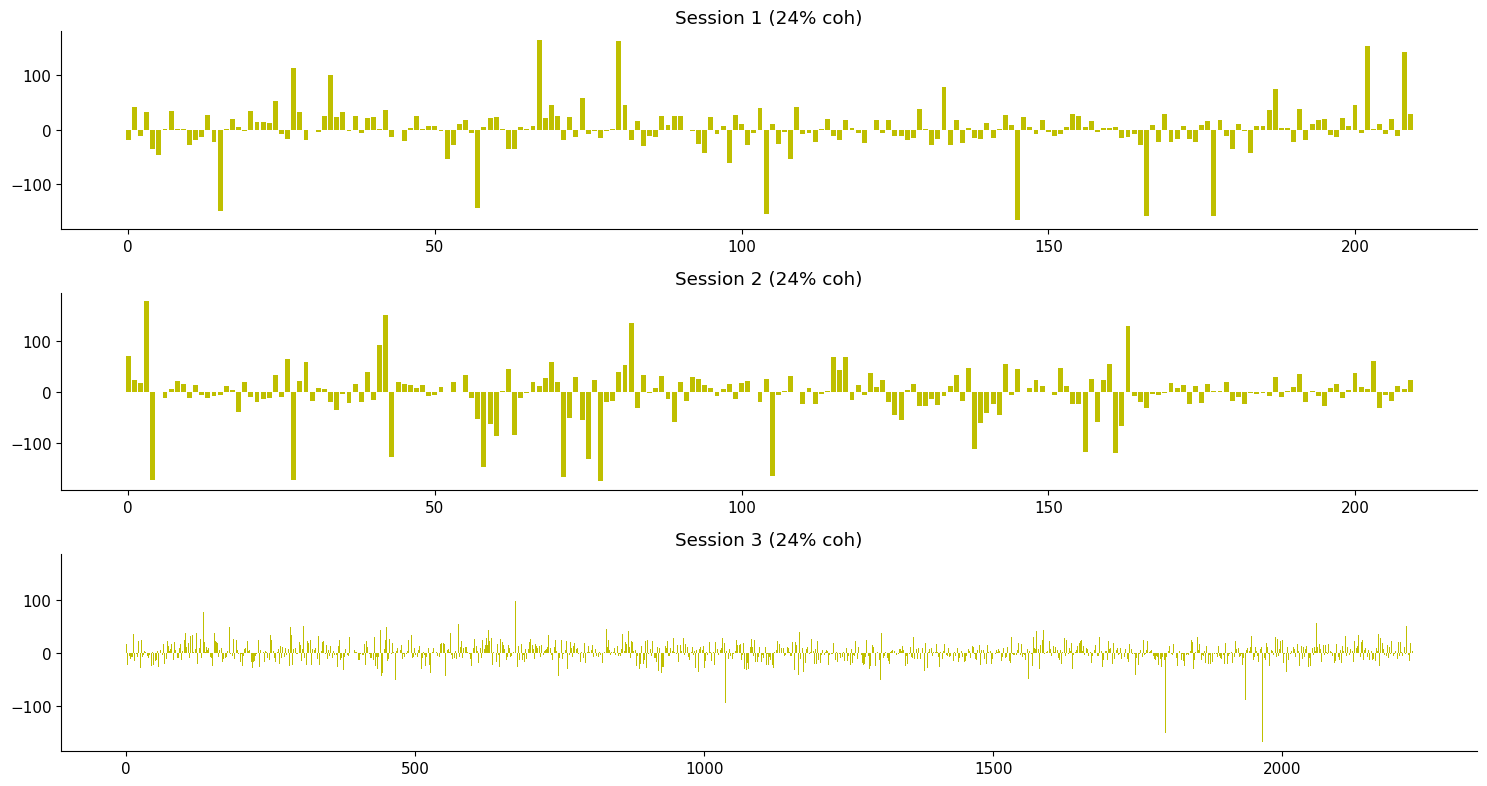

In [21]:
# @title Do estimate errors stay stable over time? (24% coh)
prior_colors = [[0.75, 0.75, 0],
                [1, 0.6, 0],
                [1, 0.2, 0],
                [0.5, 0, 0]]

# setup plots
fig, axes = plt.subplots(len(session_ids), figsize=(15,8))

# plot motion directions and choice estimates time course
for s_i, session_id in enumerate(session_ids):

    # query the data we need
    tmp = data[(data["subject_id"]==SUBJECT_ID) & (data["session_id"]==session_id) & (data["motion_coherence"]==COHERENCE)]

    # get data
    motion_direction = tmp["motion_direction"].values
    estimates_deg = np.round(get_cartesian_to_deg(tmp["estimate_x"].values, tmp["estimate_y"].values, False))

    # calculate circular error
    error = get_signed_angle(
        motion_direction, estimates_deg, type='polar'
    )

    # plot circular error
    axes[s_i].bar(x=np.arange(0, len(estimates_deg),1), height=error, color=prior_colors[p_i]);

    # add legend

    axes[s_i].set_title(f"Session {session_id} (24% coh)");